# Model RESISC 45

In [66]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging
import contextlib
import random
import platform
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from torch import nn


logger = logging.getLogger('train')
logger.setLevel(logging.INFO)

print(platform.platform())  # print current platform
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

macOS-13.3.1-arm64-arm-64bit
PyTorch Version:  2.0.0
Torchvision Version:  0.15.1


## Set constants

In [67]:
RESISC45_DIRPATH = "/Users/cristianion/Desktop/satimg_data/NWPU-RESISC45"

RESISC45_LABELS = [
    'forest',
    'railway_station',
    'tennis_court',
    'basketball_court',
    'river',
    'storage_tank',
    'harbor',
    'terrace',
    'thermal_power_station',
    'golf_course',
    'runway',
    'roundabout',
    'bridge',
    'industrial_area',
    'baseball_diamond',
    'mobile_home_park',
    'overpass',
    'church',
    'chaparral',
    'railway',
    'stadium',
    'medium_residential',
    'sea_ice',
    'intersection',
    'lake',
    'palace',
    'airplane',
    'cloud',
    'sparse_residential',
    'airport',
    'snowberg',
    'parking_lot',
    'commercial_area',
    'rectangular_farmland',
    'island',
    'beach',
    'circular_farmland',
    'dense_residential',
    'ship',
    'mountain',
    'desert',
    'freeway',
    'meadow',
    'wetland',
    'ground_track_field',
]

UCMERCED_LANDUSE_DIRPATH = "/Users/cristianion/Desktop/satimg_data/UCMerced_LandUse/Images"
UCMERCED_LANDUSE_LABELS = [
    "forest",
    "buildings",
    "river",
    "mobilehomepark",
    "harbor",
    "golfcourse",
    "agricultural",
    "runway",
    "baseballdiamond",
    "overpass",
    "chaparral",
    "tenniscourt",
    "intersection",
    "airplane",
    "parkinglot",
    "sparseresidential",
    "mediumresidential",
    "denseresidential",
    "beach",
    "freeway",
    "storagetanks",
]

pd.DataFrame({'label': RESISC45_LABELS}).to_csv("resisc45_labels.csv", index=False, header=False)
pd.DataFrame({'label': UCMERCED_LANDUSE_LABELS}).to_csv("ucmercedlu_labels.csv", index=False, header=False)

RESISC45_DATASET_FILE = "resisc45_dataset.csv"
UCMERCEDLU_DATASET_FILE = "ucmercedlu_dataset.csv"

K_FOLDS = 5

In [68]:
print(len(RESISC45_LABELS))  # number of expected labels
print(len(UCMERCED_LANDUSE_LABELS))

45
21


# Prepare dataset

In [69]:
def _parition_dataset_in_folds(data, folds=5):
    # partition the dataset into folds
    parition_size = int(100 / folds)
    print(f"Partition size {parition_size}")
    data = data.sample(frac=1).reset_index(drop=True)  # resample dataset randomly.
    print(f"Number of samples {len(data)}")

    out, bins = pd.cut(np.arange(len(data)), bins=folds, include_lowest=False, labels=[i for i in range(folds)], retbins=True)
    print(bins.tolist())
    fold = pd.Series(out)
    print(fold.unique())
    print(fold.value_counts())

    data['fold'] = fold

    data.sort_values(by=['label_index'], inplace=True)  # sort values
    return data


def dataset_imgpath_label(dataset_file: str, dirpath, labels, kfolds=5):
    filelist = [(f"{dirpath}/{f}", labels[labels.index(f)]) for f in os.listdir(dirpath) if f in labels]
    df = pd.DataFrame(filelist, columns=['dirpath', 'label'])
    print(df.head())
    print(df.info())
    data = []
    for i, dirpath in enumerate(df["dirpath"]):
        images = os.listdir(dirpath)
        images = [f"{dirpath}/{img}" for img in images]
        rows = [(img, df['label'][i]) for img in images]
        data.extend(rows)
    data = pd.DataFrame(data, columns=["imgpath", "label"])

    label_index = []
    for t in data.label:
        label_index.append(labels.index(t))
    data['label_index'] = label_index

    print(data.head())
    print(data.info())
    print(data['label'].value_counts())
    print(data['label_index'].value_counts())

    # partition the dataset in K-Folds
    data = _parition_dataset_in_folds(data, folds=kfolds)

    # save dataset on disk
    data.to_csv(dataset_file, index=False) 

    return data
    

In [71]:
resisc45_data = dataset_imgpath_label(RESISC45_DATASET_FILE, RESISC45_DIRPATH, RESISC45_LABELS)

                                             dirpath             label
0  /Users/cristianion/Desktop/satimg_data/NWPU-RE...            forest
1  /Users/cristianion/Desktop/satimg_data/NWPU-RE...   railway_station
2  /Users/cristianion/Desktop/satimg_data/NWPU-RE...      tennis_court
3  /Users/cristianion/Desktop/satimg_data/NWPU-RE...  basketball_court
4  /Users/cristianion/Desktop/satimg_data/NWPU-RE...             river
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dirpath  45 non-null     object
 1   label    45 non-null     object
dtypes: object(2)
memory usage: 852.0+ bytes
None
                                             imgpath   label  label_index
0  /Users/cristianion/Desktop/satimg_data/NWPU-RE...  forest            0
1  /Users/cristianion/Desktop/satimg_data/NWPU-RE...  forest            0
2  /Users/cristianion/Desktop/satimg_data/NWPU-RE...

Conclusions:
- 31500 annotated images
- Each category of the 45 categories has 700 samples

In [72]:
ucmercedlu_data = dataset_imgpath_label(UCMERCEDLU_DATASET_FILE, UCMERCED_LANDUSE_DIRPATH, UCMERCED_LANDUSE_LABELS)

                                             dirpath           label
0  /Users/cristianion/Desktop/satimg_data/UCMerce...          forest
1  /Users/cristianion/Desktop/satimg_data/UCMerce...       buildings
2  /Users/cristianion/Desktop/satimg_data/UCMerce...           river
3  /Users/cristianion/Desktop/satimg_data/UCMerce...  mobilehomepark
4  /Users/cristianion/Desktop/satimg_data/UCMerce...          harbor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dirpath  21 non-null     object
 1   label    21 non-null     object
dtypes: object(2)
memory usage: 468.0+ bytes
None
                                             imgpath   label  label_index
0  /Users/cristianion/Desktop/satimg_data/UCMerce...  forest            0
1  /Users/cristianion/Desktop/satimg_data/UCMerce...  forest            0
2  /Users/cristianion/Desktop/satimg_data/UCMerce...  forest    

## Sample subset of images from dataset

- show a subset of the images
- select some random labels (max 5 labels)
- show 5 images for each label to show variance
- contains varying spatial resolution ranging from 20cm to more than 30m/px.

In [73]:
def show_some_samples(data, labels):
    # extract some random labels and plot samples
    random_labels = random.sample(labels, max(5, len(labels)))
    for label in random_labels:
        subset = data[data['label'] == label].imgpath
        img_subset = subset.tolist()
        p1 = []
        for img in img_subset[:5]:
            x = cv2.imread(img)
            p1.append(x)
        
        plt.figure(figsize=(16,10))
        for i in range(1, 6):
            plt.subplot(2, 5, i)
            plt.grid(False)
            plt.imshow(p1[i-1])
            plt.xlabel(label)
        plt.show()

## RESISC45 Samples

IndexError: list index out of range

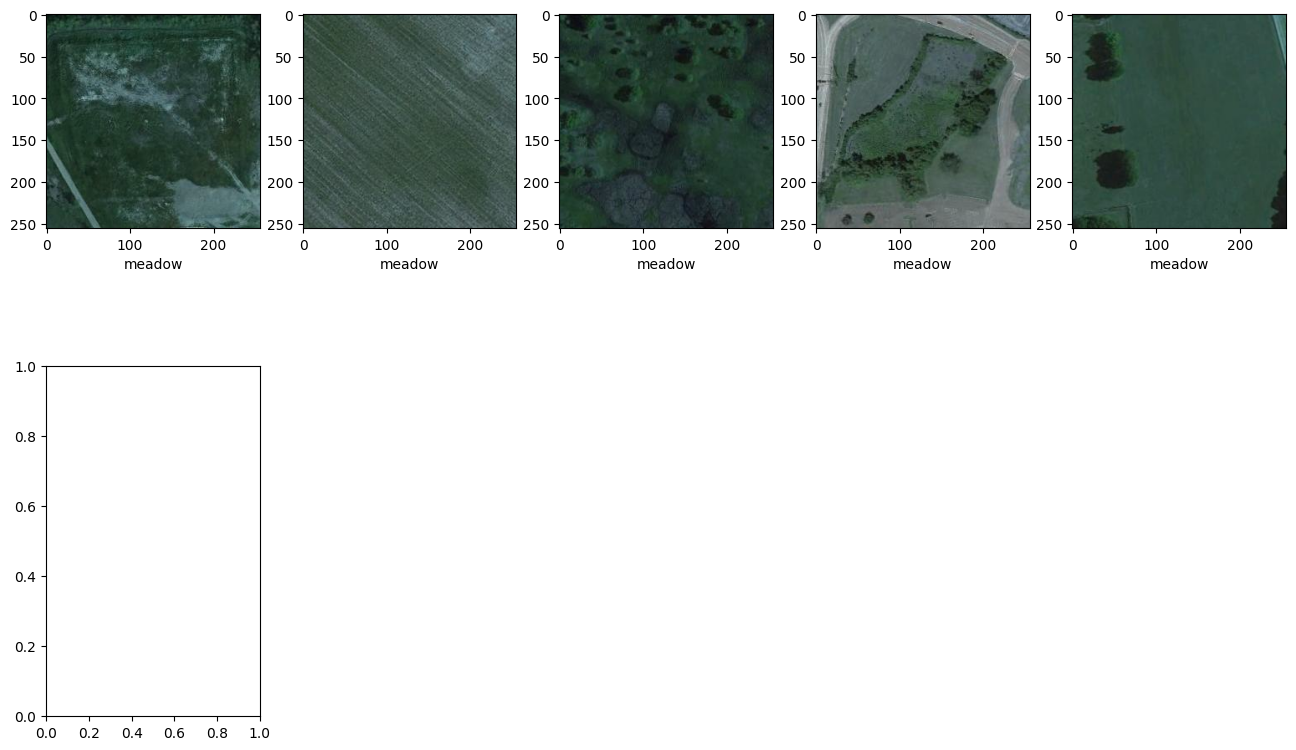

In [74]:
show_some_samples(resisc45_data, RESISC45_LABELS)

Conclusion
- Images have a resolution of 256 by 256 and 3 channels (RGB)

## UC Merced Land Use Samples

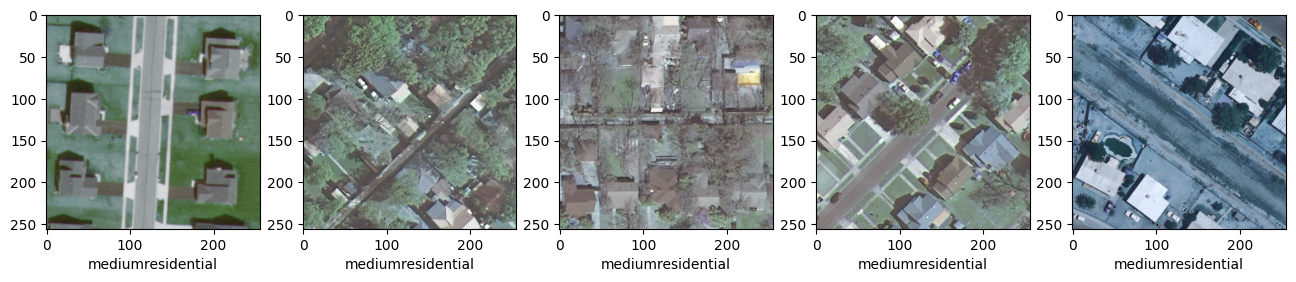

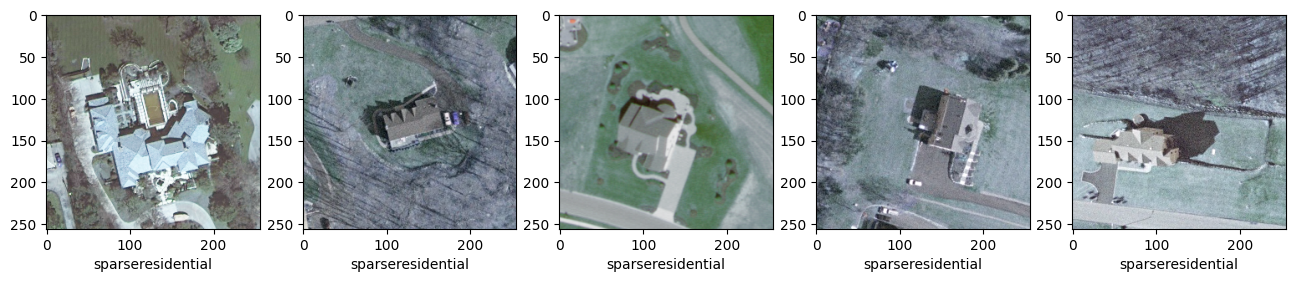

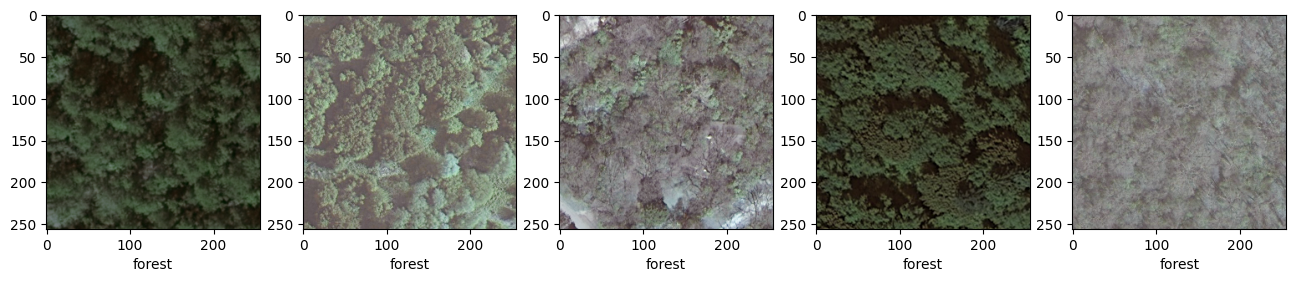

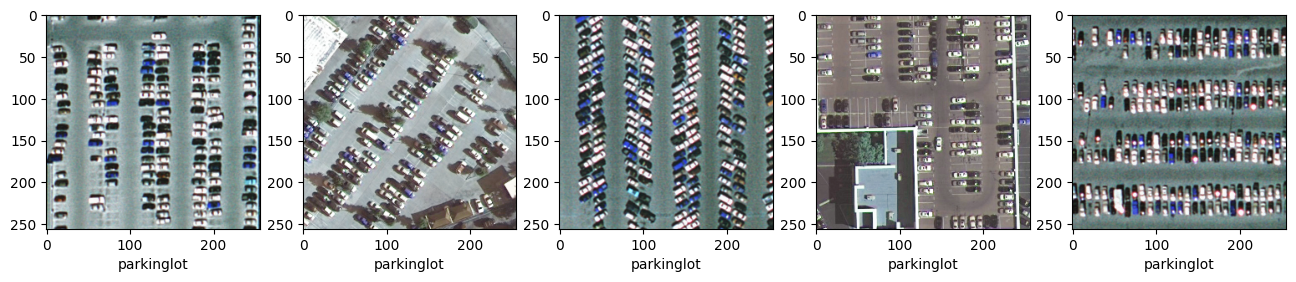

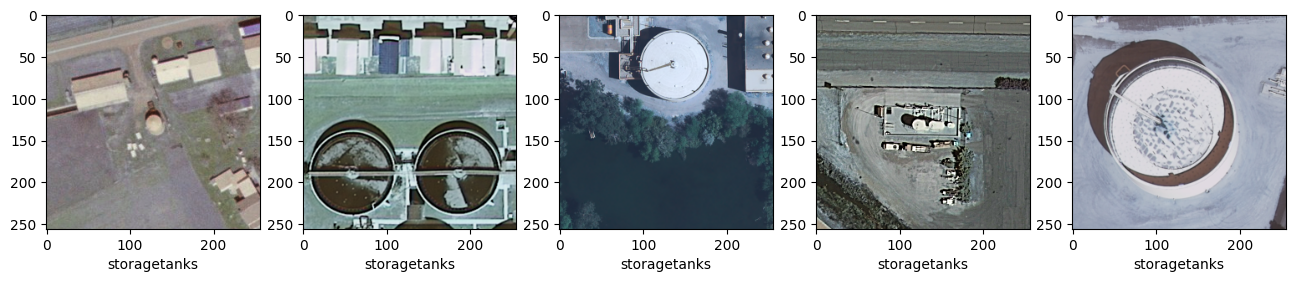

In [65]:
show_some_samples(ucmercedlu_data, UCMERCED_LANDUSE_LABELS)

## Dataset load

In [28]:
DATASET_FILE = "dataset_resisc45.csv"

In [29]:
df = pd.read_csv(DATASET_FILE)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   imgpath      31500 non-null  object
 1   label        31500 non-null  object
 2   label_index  31500 non-null  int64 
 3   fold         31500 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 984.5+ KB


In [31]:
df["fold"].value_counts()

fold
2    6300
1    6300
4    6300
0    6300
3    6300
Name: count, dtype: int64

- 6300 samples in each fold.

## Train dataset loader

In [40]:
from utils import DatasetResisc45, DatasetConfig, get_pretrained_transforms, DatasetTypeEnum

In [41]:
RES_X = 224
RES_Y = 224

In [42]:
dataset = DatasetResisc45(DatasetConfig(
    dataset_file=DATASET_FILE,
    transform=get_pretrained_transforms(224, dataset_type=DatasetTypeEnum.val),
))

# Classification problem

- 5-fold cross validation
- one-vs-all
- softmax

In [59]:
# find CUDA / MPS / CPU device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Neural Networks Algorithms

In [27]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(optimizer, dataloader, model):
    num_batches = len(dataloader)

    print("Started train.")
    size = len(dataloader.dataset)
    
    model.train()  # set model to train mode

    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    return train_loss

def val_one_epoch(dataloader, model):
    print("Started validation.")
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval() # set model to evaluation mode

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            error = (nn.Softmax(dim=1)(pred).argmax(1) == y.argmax(1)).type(torch.float)
            correct += error.sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [94]:
%matplotlib ipympl

def plot_validation_epochs(epochs, train_loss, val_loss, fold):
    fig, ax = plt.subplots()
    ax.plot(epochs, train_loss, label='train loss')
    ax.plot(epochs, val_loss, label='val loss')
    ax.legend()
    #specify axis tick step sizes
    _ = plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
    # _ = plt.yticks(np.arange(0, max(y)+0.1, 0.1))

    ax.set_title(f"Train validation by epoch. Fold {fold}")
    plt.show()

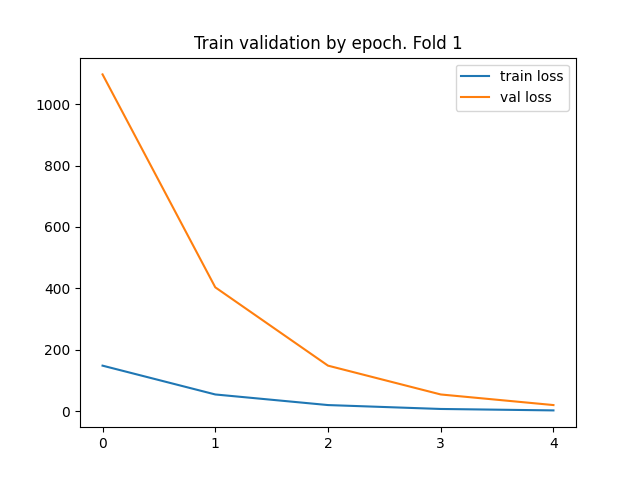

In [95]:
plot_validation_epochs(np.arange(0, 5, 1), np.exp([5, 4, 3, 2, 1]), np.exp([7, 6, 5, 4, 3]), 1)

## 5 Fold train validation

- trebuie sa reducem timpii de antrenament

## Pretrained finetuning

In [97]:
model_name = "resnet"
num_classes = len(RESISC45_LABELS)

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


# Initialize the model for this run
clf, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(clf)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [98]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Fold: 5
------------------------------


/Users/cristianion/Desktop/satimg_model/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cristianion/Desktop/satimg_model/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

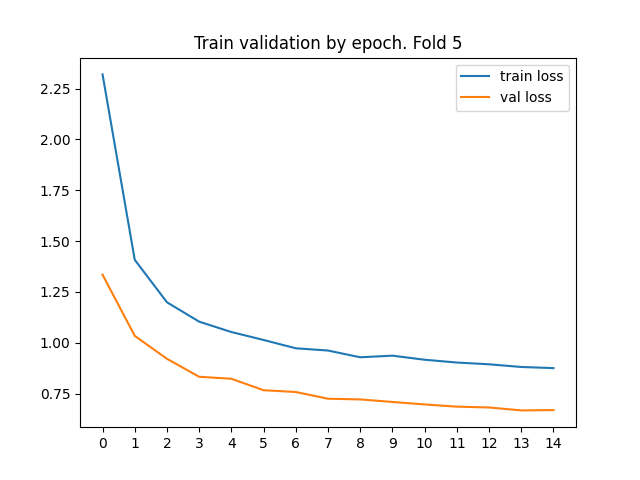

In [99]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
num_epochs = 15
val_fold = 5

print(f"Fold: {val_fold}\n------------------------------")
train_set = DatasetResisc45("dataset_resisc45.csv", transform=data_transforms['train'], dataset_type=DatasetTypeEnum.train, val_fold=val_fold)
val_set = DatasetResisc45("dataset_resisc45.csv", transform=data_transforms['val'], dataset_type=DatasetTypeEnum.val, val_fold=val_fold)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Initialize the model for this run
clf, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(clf)
clf = clf.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = clf.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in clf.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in clf.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Train and evaluate
train_losses = []
val_losses = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_one_epoch(optimizer_ft, train_dataloader, clf)
    val_loss = val_one_epoch(val_dataloader, clf)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plot_validation_epochs([i for i in range(num_epochs)], train_losses, val_losses, val_fold)